# Gaussian clusters

In [1]:
from __future__ import print_function, division
import sys, os, time, pickle, mkl
#limit the number of threds numpy/scipy are using
nthreads = 15
mkl.set_num_threads(nthreads)
os.environ["OMP_NUM_THREADS"] = str(nthreads)
import numpy as np
import multiprocessing as mp
from sklearn.datasets.samples_generator import make_blobs

# plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

mpl.rcParams['figure.titlesize'] = 30
mpl.rcParams['axes.titlesize']   = 30
mpl.rcParams['axes.labelsize']   = 20
mpl.rcParams['xtick.labelsize']  = 20
mpl.rcParams['ytick.labelsize']  = 20
mpl.rcParams['legend.fontsize']  = 20
mpl.rc('text', usetex=True)

# Custom pyscripts
maindir = '/home/lanhuong/Projects/ManifoldLearning/DiffusionTSNE'
#maindir = '/Users/lanhuong/MEGA/BIOSTATS GROUP/Projects/ManifoldLearning/DiffusionTSNE'
#maindir = '/home/lanhuong/MEGA/BIOSTATS GROUP/Projects/ManifoldLearning/DiffusionTSNE'
os.chdir(maindir)

from diffusion_tsne import diffusion_tsne
from plotting import *
from generate_data import *
from utils import *
from metrics import *

%load_ext autoreload
%autoreload 2

MACHINE_EPSILON = np.finfo(np.double).eps

def bw(betas):
    return np.sqrt(1/(2*betas))

# Equal density and equal variance 2D

In [11]:
clst_means = [[0, 0], [15, 15]]
clst_std = [1, 1]
clst_n_samples  = [2500, 2500]
X, color = make_blobs(
    n_samples=clst_n_samples, n_features=len(clst_means[0]), 
    centers=clst_means, cluster_std = clst_std, random_state=0)
idx = np.argsort(color)
X = X[idx, :]
color = color[idx]
color = np.array([["C1", "C2"][i] for i in color])
X.shape

(5000, 2)

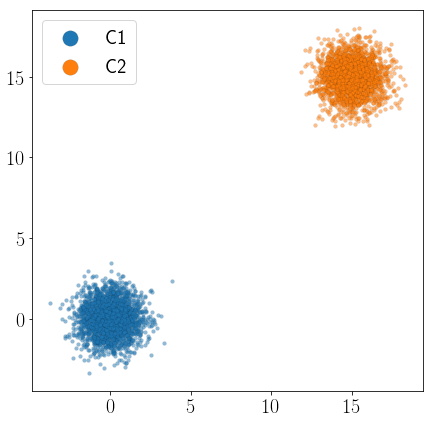

In [68]:
plot2D(X, label=color, s=15, figsize=(7,7), alpha=0.5)
plt.axis('equal')
leg = plt.legend(markerscale = 4)
for lh in leg.legendHandles: 
    lh.set_alpha(1)

(-4.84651220681423, 19.399105890578415, -4.467669131267694, 19.078492433211252)

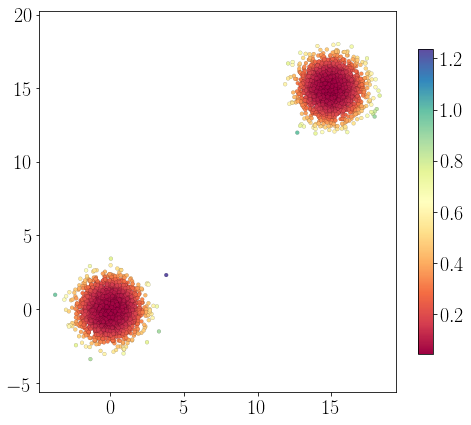

In [59]:
Y_fitsne = diffusion_tsne( 
    X, perplexity= 300, seed=123, nthreads=nthreads,
    scale_probs=False, load_affinities = "save only")
betas = np.fromfile('betas.dat', dtype=np.dtype('d'))
plot2D(X, label=1/(2*betas), s=15, figsize=(8,7))
plt.axis('equal')

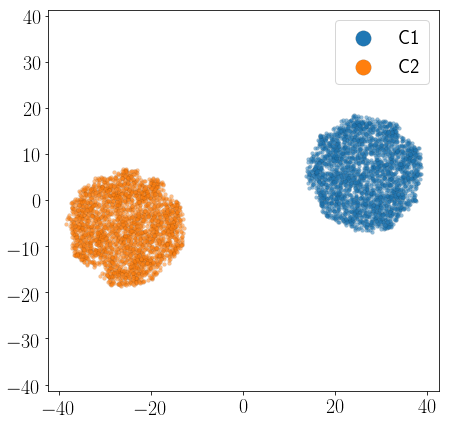

In [62]:
from sklearn.manifold import TSNE
perp = 300
start = time.time()
Y = TSNE(n_components=2, perplexity=perp).fit_transform(X)
end = time.time()
print('t-SNE embedding in %f sec' %(end-start))
plot2D(Y, label=color, s=15, figsize=(7,7), alpha = 0.5)
plt.axis('equal')
leg = plt.legend(markerscale = 4)
for lh in leg.legendHandles: 
    lh.set_alpha(1)

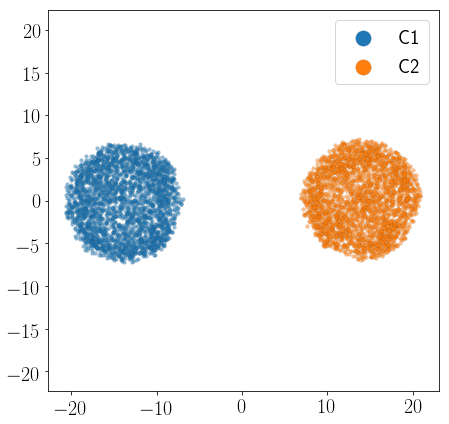

In [66]:
start = time.time()
Y_fixed = diffusion_tsne(X, perplexity=-1, sigma = 2, K = perp,
                         seed=123, nthreads=nthreads, 
                         knn_algo='vp-tree', nbody_algo = 'Barnes-Hut')
                         
end = time.time()
print('Fixed bandwidth t-SNE embedding in %f sec' %(end-start))
plot2D(Y_fixed, label=color,  s=15, figsize=(7,7), alpha = 0.5)
plt.axis('equal')
leg = plt.legend(markerscale = 4)
for lh in leg.legendHandles: 
    lh.set_alpha(1)

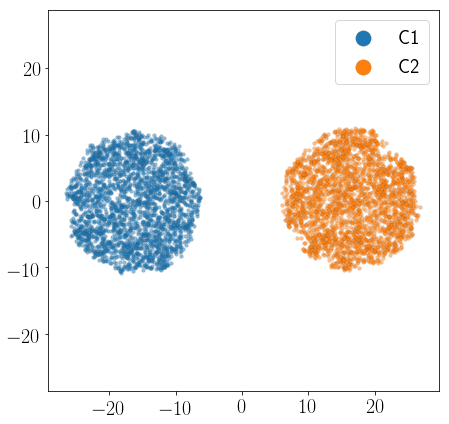

In [72]:
start = time.time()
Y_fitsne, loss = diffusion_tsne( 
    X, perplexity= perp, seed=123, nthreads=nthreads,
    scale_probs=False, load_affinities = "save", return_loss = True, 
     knn_algo='vp-tree', nbody_algo = "Barnes-Hut")
end = time.time()
betas = np.fromfile('betas.dat', dtype=np.dtype('d'))
degrees = np.fromfile('affinity_rowsums.dat', dtype=np.dtype('d'))
meandist = np.fromfile('mean_dists.dat', dtype=np.dtype('d'))
print('t-SNE embedding in %f sec' %(end-start))
plot2D(Y_fitsne, label=color, s=15, figsize=(7,7), alpha = 0.5)
plt.axis('equal')
leg = plt.legend(markerscale = 4)
for lh in leg.legendHandles: 
    lh.set_alpha(1)

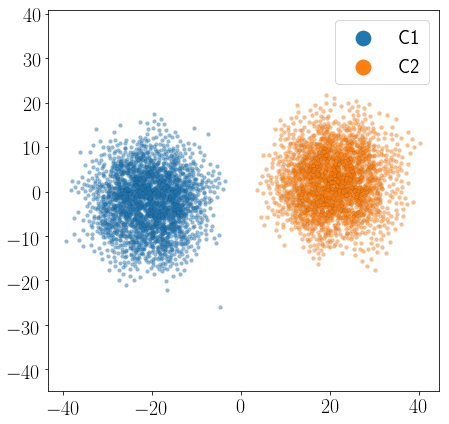

In [73]:
start = time.time()
Y_fitsne_scale, loss = diffusion_tsne( 
    X, perplexity= perp, seed=123, nthreads=nthreads,
    scale_probs=True, load_affinities = "save", return_loss = True, 
    max_iter=5000, early_exag_coeff = 12, learning_rate = 50,
    knn_algo='vp-tree' ,nbody_algo = "Barnes-Hut")
end = time.time()
print('t-SNE embedding in %f sec' %(end-start))
plot2D(Y_fitsne_scale, label=color, s=15, figsize=(7,7), alpha = 0.5)
plt.axis('equal')
leg = plt.legend(markerscale = 4)
for lh in leg.legendHandles: 
    lh.set_alpha(1)

(-43.48402944304256, 44.30088671843591, -28.49284377022649, 24.22825250673766)

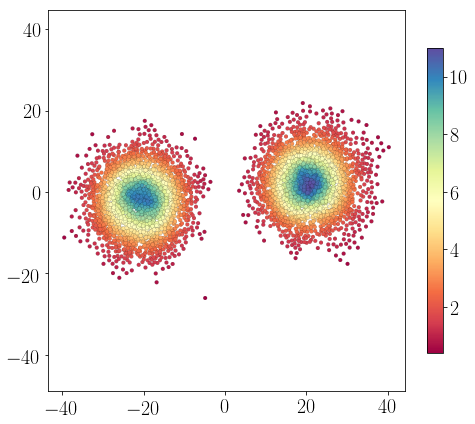

In [71]:
plot2D(Y_fitsne_scale, label=betas, s=15, figsize=(8,7))
plt.axis('equal')

(-48.11154409476013, 47.96897338736514, -29.45788376310408, 24.609233853287343)

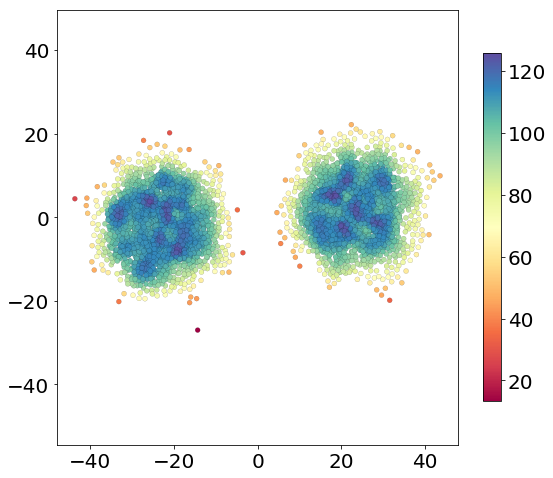

In [66]:
plot2D(Y_fitsne_scale, label=degrees, s=15, figsize=(8,7))
plt.axis('equal')

(-43.485418016428724,
 44.302275291822085,
 -28.494472749411777,
 24.22988148592295)

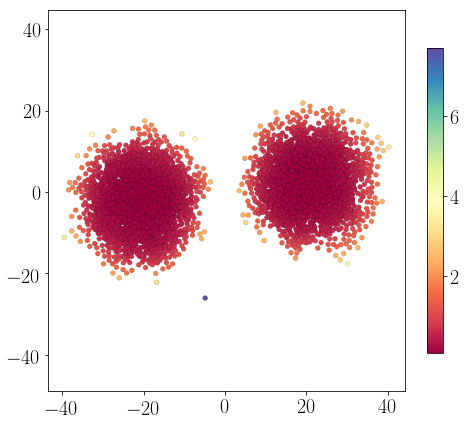

In [74]:
plot2D(Y_fitsne_scale, label=meandist, s=25, figsize=(8,7))
plt.axis('equal')

# Equal density different variance

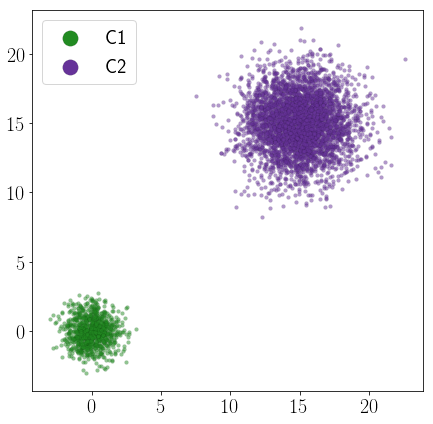

In [84]:
clst_means = [[0, 0], [15, 15]]
clst_std = [1, 2]
clst_n_samples  = [1000, 4*1000]
X1, color1 = make_blobs(
    n_samples=clst_n_samples, n_features=len(clst_means[0]), 
    centers=clst_means, cluster_std = clst_std, random_state=0)
idx = np.argsort(color1)
X1 = X1[idx, :]
color1 = color1[idx]
color1 = np.array([["C1", "C2"][i] for i in color1])

plot2D(X1, label=color1, col_map = ["forestgreen", "rebeccapurple"],
       s=15, figsize=(7,7), alpha = 0.5)
leg = plt.legend(markerscale = 4)
for lh in leg.legendHandles: 
    lh.set_alpha(1)

(-4.279281345614776,
 23.887988915321383,
 -4.296802035646075,
 23.105736074851134)

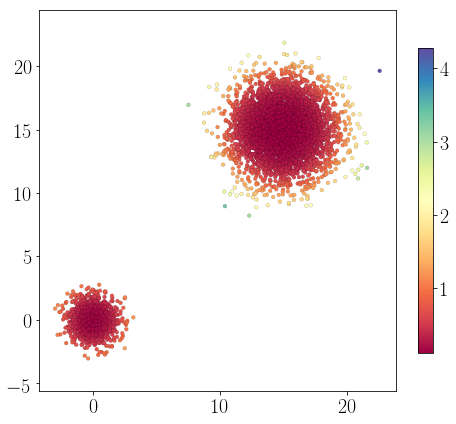

In [79]:
Z = diffusion_tsne( 
    X1, perplexity= 300, seed=123, nthreads=nthreads,
    scale_probs=False, load_affinities = "save only")
betas1 = np.fromfile('betas.dat', dtype=np.dtype('d'))
plot2D(X1, label=1/(2*betas1), s=15, figsize=(8,7))
plt.axis('equal')

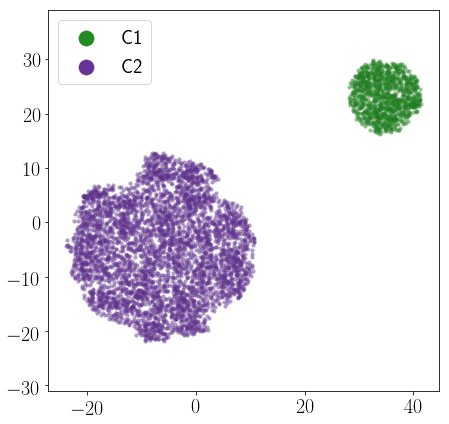

In [85]:
from sklearn.manifold import TSNE
start = time.time()
Y1 = TSNE(n_components=2, perplexity=perp).fit_transform(X1)
end = time.time()
print('t-SNE embedding in %f sec' %(end-start))
plot2D(Y1, label=color1, s=15, figsize=(7,7), 
       col_map = ["forestgreen", "rebeccapurple"], alpha = 0.5)
plt.axis('equal')
leg = plt.legend(markerscale = 4)
for lh in leg.legendHandles: 
    lh.set_alpha(1)

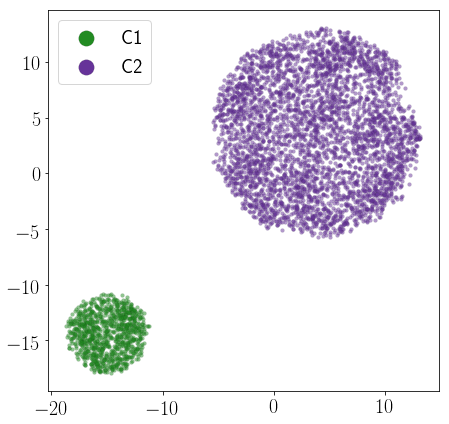

In [86]:
start = time.time()
Y_fixed1 = diffusion_tsne(X1, perplexity=-1, sigma = 2, K = perp,
                         seed=123, nthreads=nthreads, 
                         knn_algo='vp-tree', nbody_algo = 'Barnes-Hut')
end = time.time()
print('Fixed bandwidth t-SNE embedding in %f sec' %(end-start))
plot2D(Y_fixed1, label=color1, s=15, figsize=(7,7),
      col_map = ["forestgreen", "rebeccapurple"], alpha = 0.5)
plt.axis('equal')
leg = plt.legend(markerscale = 4)
for lh in leg.legendHandles: 
    lh.set_alpha(1)

t-SNE embedding in 29.197081 sec


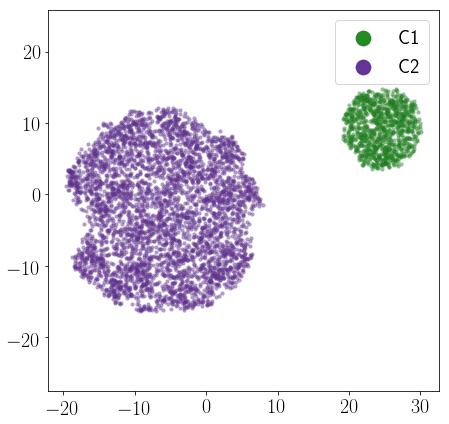

In [87]:
start = time.time()
Y_fitsne1 = diffusion_tsne(
    X1, perplexity=perp, seed=3465, nthreads=nthreads, 
    scale_probs=False,  load_affinities = "save",
    knn_algo='vp-tree', nbody_algo = 'Barnes-Hut')
end = time.time()
betas1 = np.fromfile('betas.dat', dtype=np.dtype('d'))
degrees1 = np.fromfile('affinity_rowsums.dat', dtype=np.dtype('d'))
meandist1 = np.fromfile('mean_dists.dat', dtype=np.dtype('d'))
print('t-SNE embedding in %f sec' %(end-start))
plot2D(Y_fitsne1, label=color1, col_map = ["forestgreen", "rebeccapurple"],
       s=15, figsize=(7,7), alpha = 0.5)
plt.axis('equal')
leg = plt.legend(markerscale = 4)
for lh in leg.legendHandles: 
    lh.set_alpha(1)

t-SNE embedding in 124.838316 sec


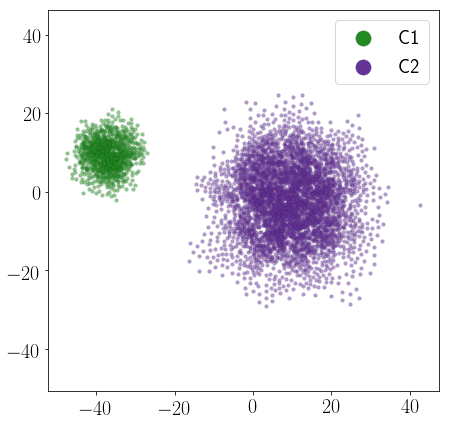

In [88]:
start = time.time()
Y_fitsne_scale1 = diffusion_tsne(
    X1, perplexity=perp, seed=756, nthreads=nthreads, 
    max_iter=5000, early_exag_coeff = 12, learning_rate = 200,
    scale_probs=True, load_affinities = "save", 
    knn_algo='vp-tree', nbody_algo = 'Barnes-Hut')
end = time.time()
print('t-SNE embedding in %f sec' %(end-start))
plot2D(Y_fitsne_scale1, label=color1, s=15, figsize=(7,7), 
       col_map = ["forestgreen", "rebeccapurple"], alpha = 0.5)
plt.axis('equal')
leg = plt.legend(markerscale = 4)
for lh in leg.legendHandles: 
    lh.set_alpha(1)

(-52.26459954368307, 47.2081132138742, -31.798317784861283, 27.332263718912152)

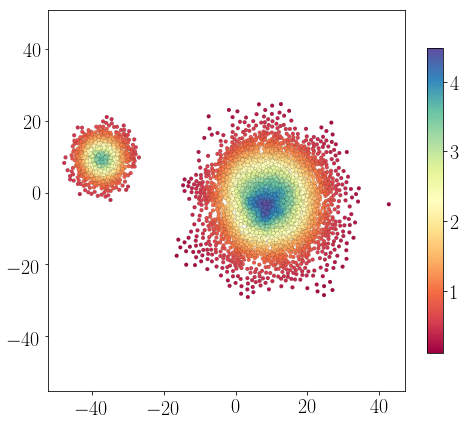

In [91]:
plot2D(Y_fitsne_scale1, label=betas1, s=15, figsize=(8,7))
plt.axis('equal')

(-52.26459954368307, 47.2081132138742, -31.798317784861283, 27.332263718912152)

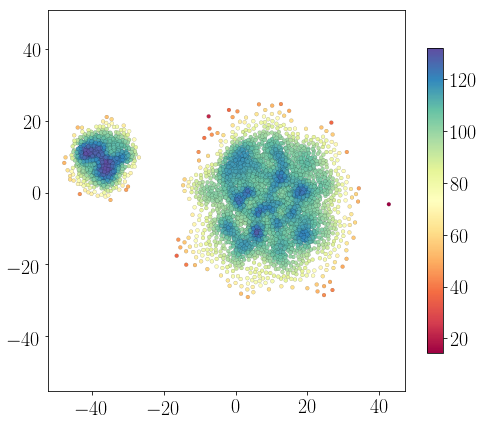

In [95]:
plot2D(Y_fitsne_scale1, label=degrees1, s=15, figsize=(8,7))
plt.axis('equal')

(-4.279281345614776,
 23.887988915321383,
 -4.296802035646075,
 23.105736074851134)

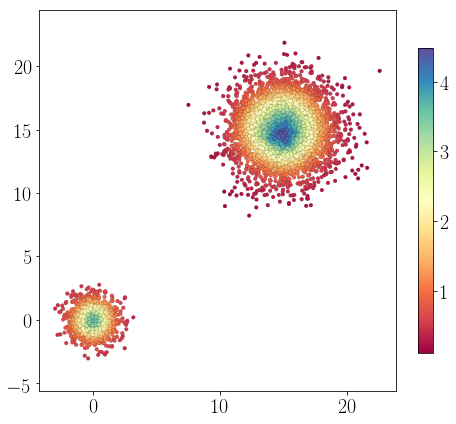

In [94]:
plot2D(X1, label=betas1, s=15, figsize=(8,7))
plt.axis('equal')

(-52.265988117069234,
 47.209501787260365,
 -31.79994676404657,
 27.33389269809744)

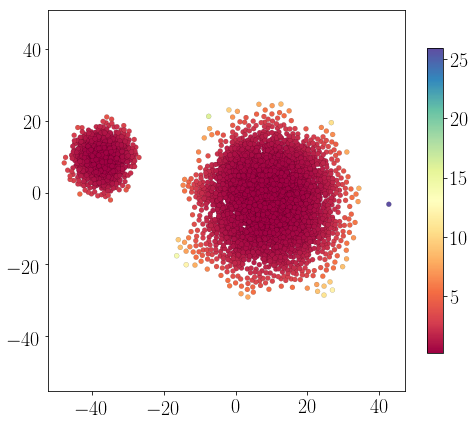

In [96]:
plot2D(Y_fitsne_scale1, label=meandist1, s=25, figsize=(8,7))
plt.axis('equal')

# Equal variance different density
Different number of observation, same variance

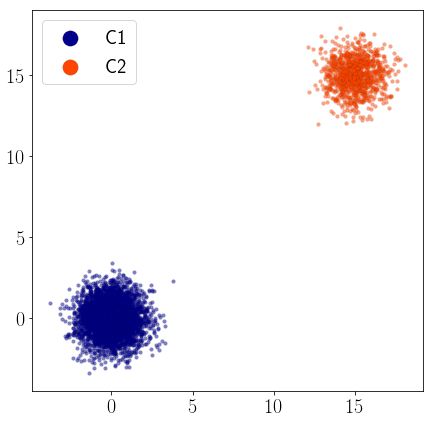

In [97]:
clst_means = [[0, 0], [15, 15]]
clst_std = [1, 1]
clst_n_samples  = [4000, 1000]
X2, color2 = make_blobs(
    n_samples=clst_n_samples, n_features=len(clst_means[0]), 
    centers=clst_means, cluster_std = clst_std, random_state=0)
idx = np.argsort(color2)
X2 = X2[idx, :]
color2 = color2[idx]
color2 = np.array([["C1", "C2"][i] for i in color2])

plot2D(X2, label=color2, s=15, figsize=(7,7),
       col_map = ["darkblue", "orangered"], alpha = 0.5)
leg = plt.legend(markerscale = 4)
for lh in leg.legendHandles: 
    lh.set_alpha(1)

(-4.832860970526046, 19.11242992852656, -4.460773143525115, 18.933676690617094)

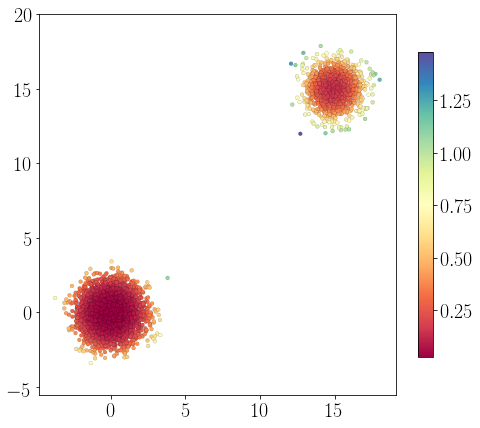

In [99]:
Z = diffusion_tsne( 
    X2, perplexity= 300, seed=123, nthreads=nthreads,
    scale_probs=False, load_affinities = "save only")
betas2 = np.fromfile('betas.dat', dtype=np.dtype('d'))
plot2D(X2, label=1/(2*betas2), s=15, figsize=(8,7))
plt.axis('equal')

t-SNE embedding in 113.049220 sec


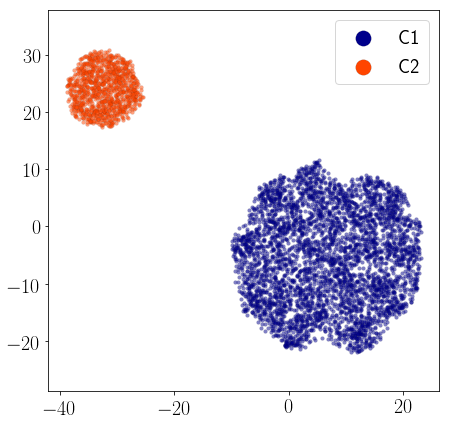

In [100]:
from sklearn.manifold import TSNE
start = time.time()
Y2 = TSNE(n_components=2, perplexity=perp).fit_transform(X2)
end = time.time()
print('t-SNE embedding in %f sec' %(end-start))
plot2D(Y2, label=color2, s=15, figsize=(7,7), 
       col_map = ["darkblue", "orangered"], alpha = 0.5)
plt.axis('equal')
leg = plt.legend(markerscale = 4)
for lh in leg.legendHandles: 
    lh.set_alpha(1)

Fixed bandwidth t-SNE embedding in 20.306861 sec


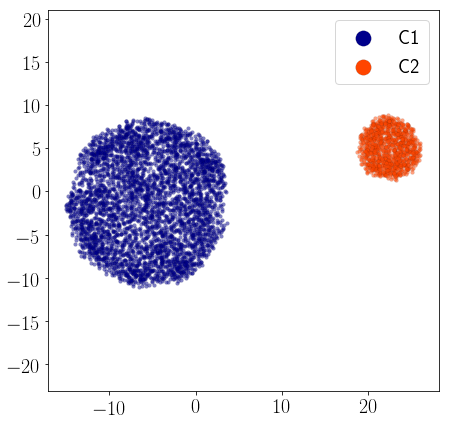

In [101]:
start = time.time()
Y_fixed2 = diffusion_tsne(
    X2, perplexity=-1, sigma = 2, K = perp,
    seed=123, nthreads=nthreads, 
    knn_algo='vp-tree', nbody_algo = 'Barnes-Hut')
end = time.time()
print('Fixed bandwidth t-SNE embedding in %f sec' %(end-start))
plot2D(Y_fixed2, label=color2, s=15, figsize=(7,7),
       col_map = ["darkblue", "orangered"], alpha = 0.5)
plt.axis('equal')
leg = plt.legend(markerscale = 4)
for lh in leg.legendHandles: 
    lh.set_alpha(1)

t-SNE embedding in 29.960369 sec


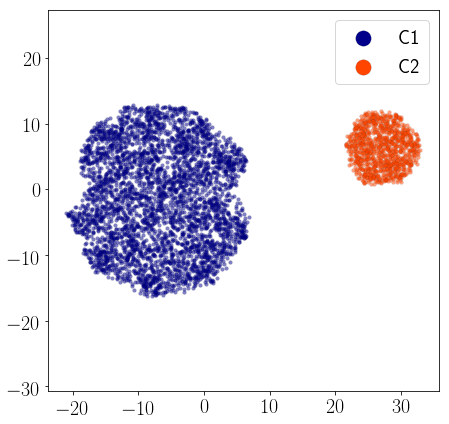

In [102]:
start = time.time()
Y_fitsne2 = diffusion_tsne(
    X2, perplexity=perp, seed=123, nthreads=nthreads, 
    scale_probs=False, load_affinities = "save", 
    knn_algo='vp-tree', nbody_algo = 'Barnes-Hut')
end = time.time()
betas2 = np.fromfile('betas.dat', dtype=np.dtype('d'))
degrees2 = np.fromfile('affinity_rowsums.dat', dtype=np.dtype('d'))
meandist2 = np.fromfile('mean_dists.dat', dtype=np.dtype('d'))

print('t-SNE embedding in %f sec' %(end-start))
plot2D(Y_fitsne2, label=color2,  s=15, figsize=(7,7),
        col_map = ["darkblue", "orangered"], alpha = 0.5)
plt.axis('equal')
leg = plt.legend(markerscale = 4)
for lh in leg.legendHandles: 
    lh.set_alpha(1)

t-SNE embedding in 124.078450 sec


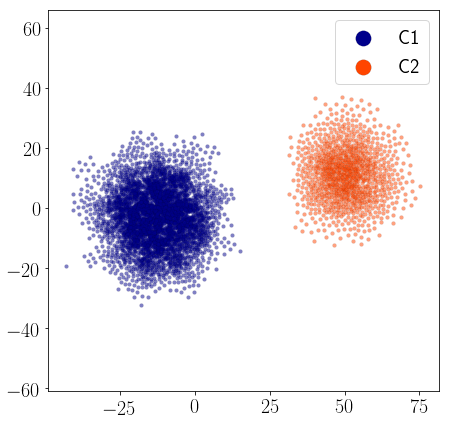

In [103]:
start = time.time()
Y_fitsne_scale2, loss = diffusion_tsne(
    X2, perplexity=perp, seed=123, nthreads=nthreads, 
    max_iter=5000, early_exag_coeff = 12, learning_rate = 500,
    scale_probs=True, load_affinities = "save", return_loss = True,
    knn_algo='vp-tree', nbody_algo = 'Barnes-Hut')
end = time.time()
print('t-SNE embedding in %f sec' %(end-start))
plot2D(Y_fitsne_scale2, label=color2,  s=15, figsize=(7,7),
       col_map = ["darkblue", "orangered"], alpha = 0.5)
plt.axis('equal')
leg = plt.legend(markerscale = 4)
for lh in leg.legendHandles: 
    lh.set_alpha(1)

(-4.832860970526046, 19.11242992852656, -4.460773143525115, 18.933676690617094)

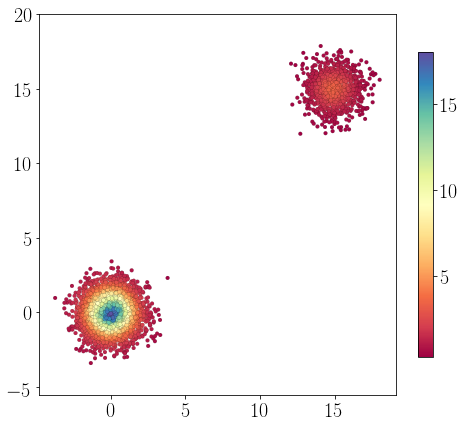

In [105]:
betas2 = np.fromfile('betas.dat', dtype=np.dtype('d'))
degrees2 = np.fromfile('affinity_rowsums.dat', dtype=np.dtype('d'))
meandist2 = np.fromfile('mean_dists.dat', dtype=np.dtype('d'))
plot2D(X2, label=betas2, s=15, figsize=(8,7))
plt.axis('equal')

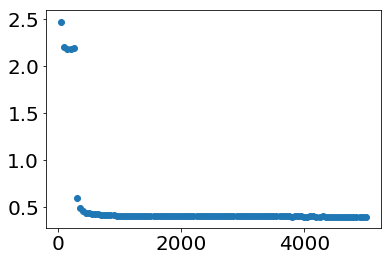

In [147]:
plt.scatter(range(len(loss)), loss)

(-49.0197798214758, 81.04537062786198, -36.096452462024104, 40.651838338411714)

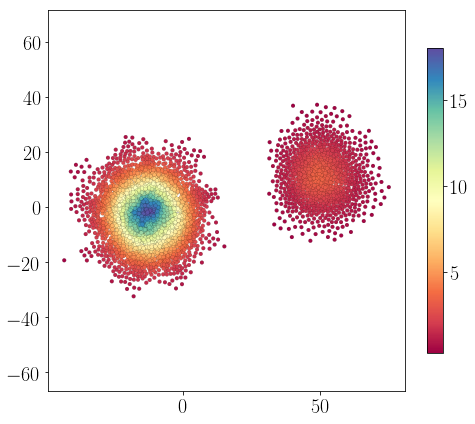

In [109]:
plot2D(Y_fitsne_scale2, label= betas2, s=15, figsize=(8,7))
plt.axis('equal')

(-49.0197798214758, 81.04537062786198, -36.096452462024104, 40.651838338411714)

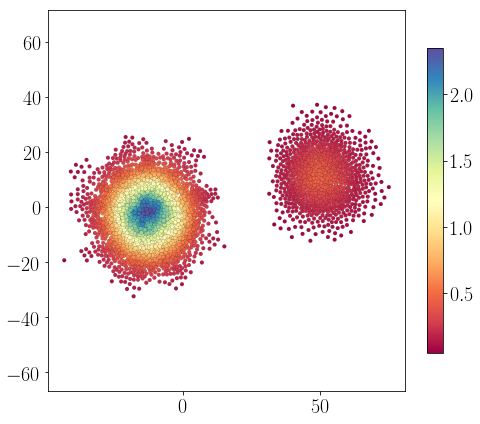

In [110]:
plot2D(Y_fitsne_scale2, label= degrees2, s=15, figsize=(8,7))
plt.axis('equal')

(-49.0197798214758, 81.04537062786198, -36.096452462024104, 40.651838338411714)

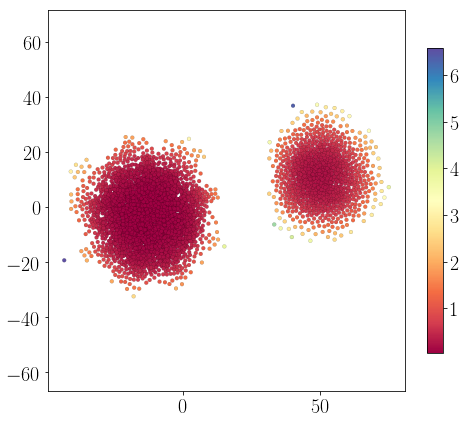

In [111]:
plot2D(Y_fitsne_scale2, label=meandist2, s=15, figsize=(8,7))
plt.axis('equal')

# Same number observations different variance

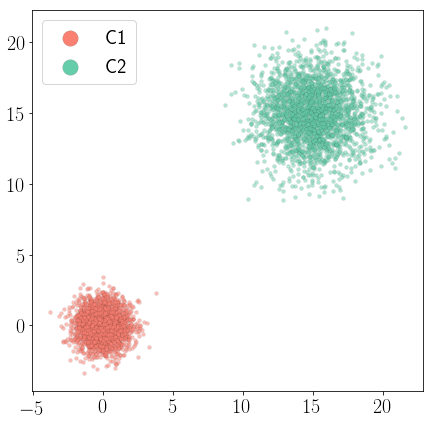

In [112]:
clst_means = [[0, 0], [15, 15]]
clst_std = [1, 2]
clst_n_samples  = [2500, 2500]
X3, color3 = make_blobs(
    n_samples=clst_n_samples, n_features=len(clst_means[0]), 
    centers=clst_means, cluster_std = clst_std, random_state=0)
idx = np.argsort(color3)
X3 = X3[idx, :]
color3 = color3[idx]
color3 = np.array([["C1", "C2"][i] for i in color3])

plot2D(X3, label=color3, s=15, figsize=(7,7),
      col_map = ["salmon", "mediumaquamarine"], alpha = 0.5)
leg = plt.legend(markerscale = 4)
for lh in leg.legendHandles: 
    lh.set_alpha(1)

(-5.0111469229000285,
 22.856434928380178,
 -4.61782529603599,
 22.231771893345478)

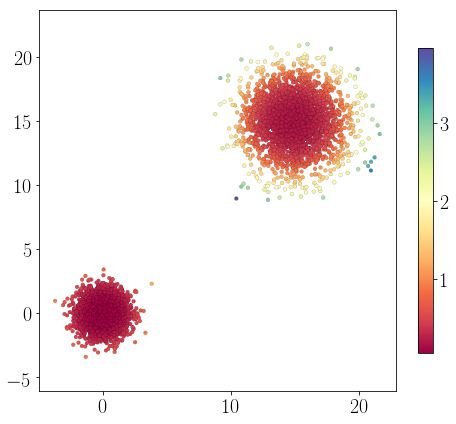

In [113]:
Z = diffusion_tsne( 
    X3, perplexity= 300, seed=123, nthreads=nthreads,
    scale_probs=False, load_affinities = "save only")
betas3 = np.fromfile('betas.dat', dtype=np.dtype('d'))
plot2D(X3, label=1/(2*betas3), s=15, figsize=(8,7))
plt.axis('equal')

t-SNE embedding in 110.223253 sec


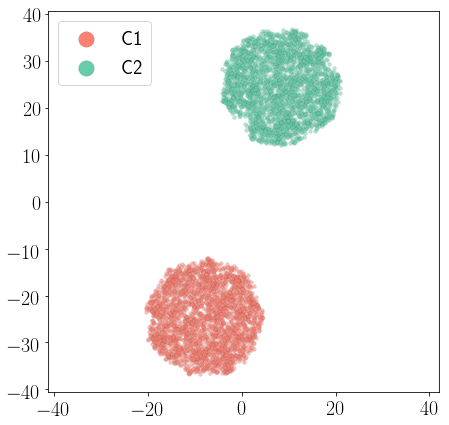

In [115]:
from sklearn.manifold import TSNE
start = time.time()
Y3 = TSNE(n_components=2, perplexity=perp).fit_transform(X3)
end = time.time()
print('t-SNE embedding in %f sec' %(end-start))
plot2D(Y3, label=color3, s=15, figsize=(7,7), 
       col_map = ["salmon", "mediumaquamarine"], alpha = 0.5)
plt.axis('equal')
leg = plt.legend(markerscale = 4)
for lh in leg.legendHandles: 
    lh.set_alpha(1)

Fixed bandwidth t-SNE embedding in 21.859403 sec


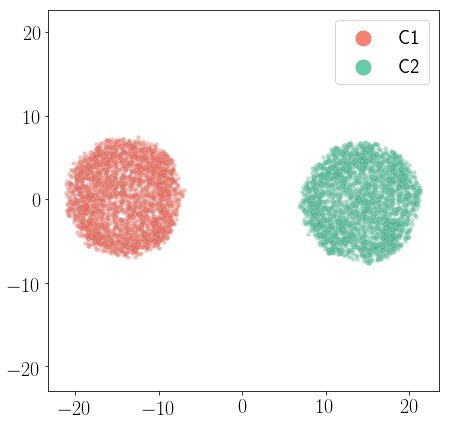

In [114]:
start = time.time()
Y_fixed3 = diffusion_tsne(
    X3, perplexity=-1, sigma = 2, K = perp,
    seed=123, nthreads=nthreads,
    knn_algo='vp-tree', nbody_algo = 'Barnes-Hut')
end = time.time()
print('Fixed bandwidth t-SNE embedding in %f sec' %(end-start))
plot2D(Y_fixed3, label=color3, s=15, figsize=(7,7),
      col_map =["salmon", "mediumaquamarine"], alpha = 0.5)
plt.axis('equal')
leg = plt.legend(markerscale = 4)
for lh in leg.legendHandles: 
    lh.set_alpha(1)

t-SNE embedding in 29.026137 sec


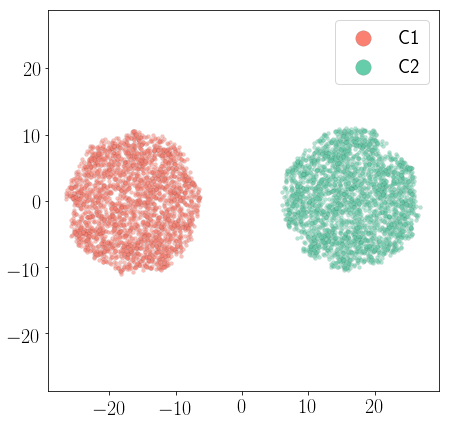

In [116]:
start = time.time()
Y_fitsne3 = diffusion_tsne(
    X3, perplexity=perp, seed=123, nthreads=nthreads, 
    scale_probs=False, load_affinities = "save", 
    knn_algo='vp-tree', nbody_algo = 'Barnes-Hut')
end = time.time()
print('t-SNE embedding in %f sec' %(end-start))
betas3 = np.fromfile('betas.dat', dtype=np.dtype('d'))
degrees3 = np.fromfile('affinity_rowsums.dat', dtype=np.dtype('d'))
meandist3 = np.fromfile('mean_dists.dat', dtype=np.dtype('d'))

plot2D(Y_fitsne3, label=color3,  s=15, figsize=(7,7),
       col_map = ["salmon", "mediumaquamarine"], alpha = 0.5)
plt.axis('equal')
leg = plt.legend(markerscale = 4)
for lh in leg.legendHandles: 
    lh.set_alpha(1)

t-SNE embedding in 133.103402 sec


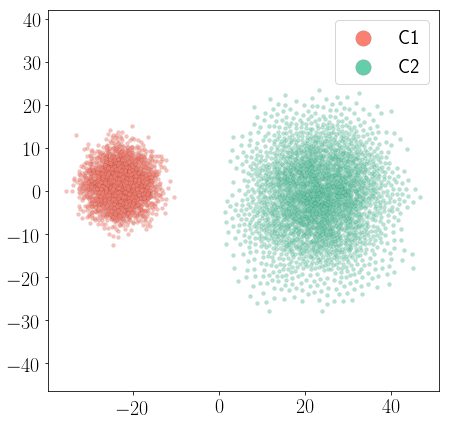

In [117]:
start = time.time()
Y_fitsne_scale3 = diffusion_tsne(
    X3, perplexity=500, seed=3587, nthreads=nthreads, 
    max_iter=5000, early_exag_coeff = 12, learning_rate = 200,
    scale_probs=True, load_affinities = "save", 
    knn_algo='vp-tree', nbody_algo = 'Barnes-Hut')
end = time.time()
print('t-SNE embedding in %f sec' %(end-start))
plot2D(Y_fitsne_scale3, label=color3,  s=15, figsize=(7,7),
       col_map = ["salmon", "mediumaquamarine"], alpha = 0.5)
plt.axis('equal')
leg = plt.legend(markerscale = 4)
for lh in leg.legendHandles: 
    lh.set_alpha(1)

(-39.853605337200634,
 50.86033046445728,
 -30.617756049447735,
 25.984191942145575)

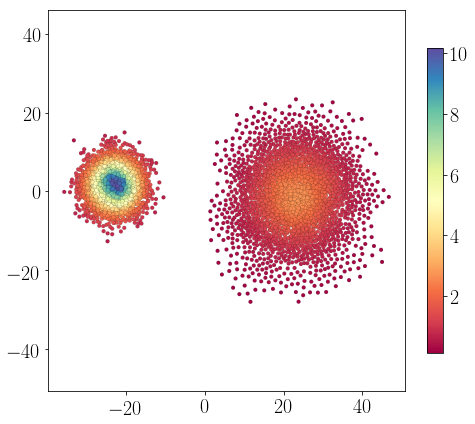

In [118]:
plot2D(Y_fitsne_scale3, label= betas3, s=15, figsize=(8,7))
plt.axis('equal')

(-39.853605337200634,
 50.86033046445728,
 -30.617756049447735,
 25.984191942145575)

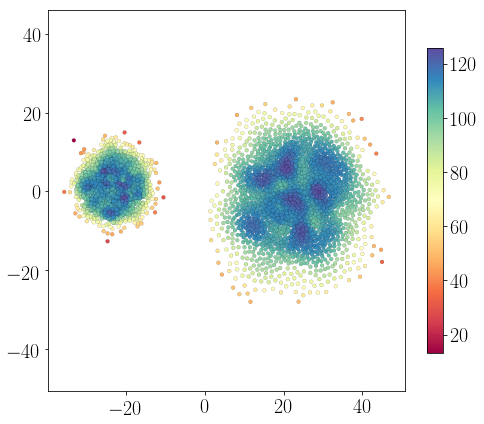

In [119]:
plot2D(Y_fitsne_scale3, label= degrees3, s=15, figsize=(8,7))
plt.axis('equal')

(-39.853605337200634,
 50.86033046445728,
 -30.617756049447735,
 25.984191942145575)

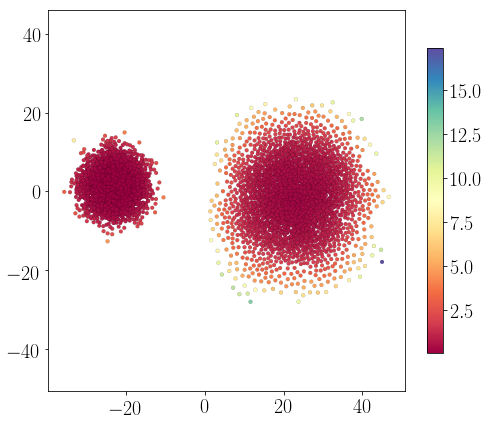

In [120]:
plot2D(Y_fitsne_scale3, label=meandist3, s=15, figsize=(8,7))
plt.axis('equal')

# Bigger cluster smaller number of observations

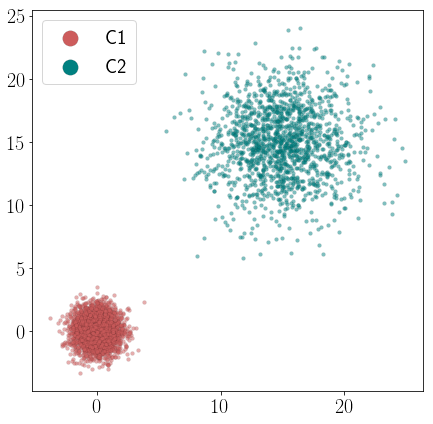

In [121]:
clst_means = [[0, 0], [15, 15]]
clst_std = [1, 3]
clst_n_samples  = [3000, 1500]
X4, color4 = make_blobs(
    n_samples=clst_n_samples, n_features=len(clst_means[0]), 
    centers=clst_means, cluster_std = clst_std, random_state=0)
idx = np.argsort(color4)
X4 = X4[idx, :]
color4 = color4[idx]
color4 = np.array([["C1", "C2"][i] for i in color4])

plot2D(X4, label=color4, s=15, figsize=(7,7),
      col_map = ["indianred", "teal"], alpha = 0.5)
plt.legend(markerscale=4)
leg = plt.legend(markerscale = 4)
for lh in leg.legendHandles: 
    lh.set_alpha(1)

(-5.175781638985827, 26.313763966181945, -4.767981460804288, 25.38505135347971)

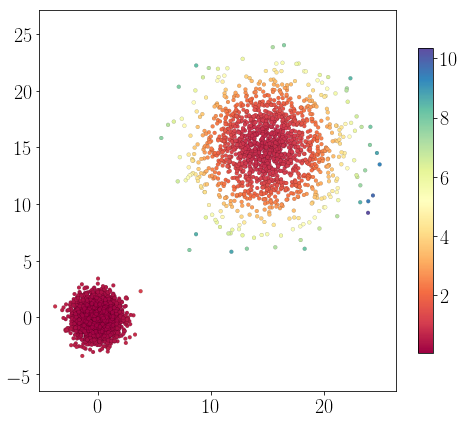

In [122]:
Z = diffusion_tsne( 
    X4, perplexity= 300, seed=123, nthreads=nthreads,
    scale_probs=False, load_affinities = "save only")
betas4 = np.fromfile('betas.dat', dtype=np.dtype('d'))
plot2D(X4, label=1/(2*betas4), s=15, figsize=(8,7))
plt.axis('equal')

t-SNE embedding in 105.888849 sec


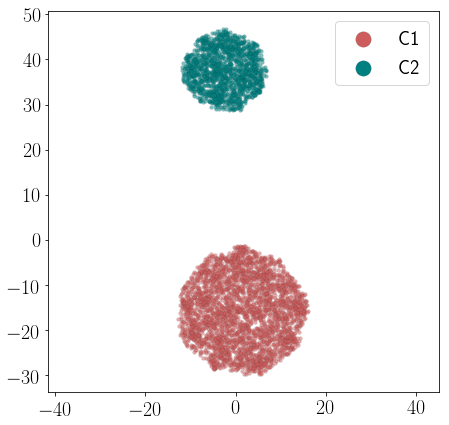

In [123]:
from sklearn.manifold import TSNE
start = time.time()
Y4 = TSNE(n_components=2, perplexity=perp).fit_transform(X4)
end = time.time()
print('t-SNE embedding in %f sec' %(end-start))
plot2D(Y4, label=color4, s=15, figsize=(7,7), 
      col_map = ["indianred", "teal"], alpha = 0.5)
plt.axis('equal')
leg = plt.legend(markerscale = 4)
for lh in leg.legendHandles: 
    lh.set_alpha(1)

Fixed bandwidth t-SNE embedding in 18.652120 sec


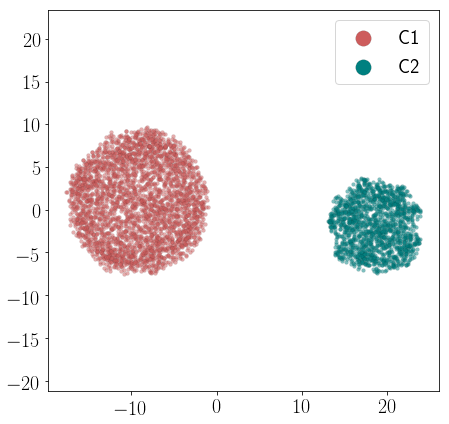

In [124]:
start = time.time()
Y_fixed4 = diffusion_tsne(
    X4, perplexity=-1, sigma = 2, K = perp,
    seed=435, nthreads=nthreads, 
    knn_algo='vp-tree', nbody_algo = 'Barnes-Hut')
end = time.time()
print('Fixed bandwidth t-SNE embedding in %f sec' %(end-start))
plot2D(Y_fixed4, label=color4, s=15, figsize=(7,7),
      col_map = ["indianred", "teal"], alpha = 0.5)
plt.axis('equal')
leg = plt.legend(markerscale = 4)
for lh in leg.legendHandles: 
    lh.set_alpha(1)

t-SNE embedding in 24.837359 sec


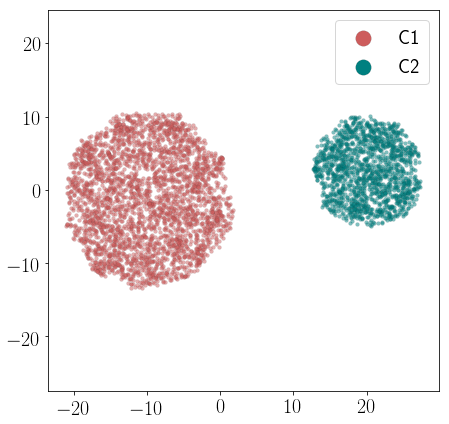

In [125]:
start = time.time()
Y_fitsne4 = diffusion_tsne(
    X4, perplexity=perp, seed=123, nthreads=nthreads, 
    scale_probs=False, load_affinities = "save", 
    knn_algo='vp-tree', nbody_algo = 'Barnes-Hut')
end = time.time()
betas4 = np.fromfile('betas.dat', dtype=np.dtype('d'))
degrees4 = np.fromfile('affinity_rowsums.dat', dtype=np.dtype('d'))
meandist4 = np.fromfile('mean_dists.dat', dtype=np.dtype('d'))

print('t-SNE embedding in %f sec' %(end-start))
plot2D(Y_fitsne4, label=color4,  s=15, figsize=(7,7),
      col_map = ["indianred", "teal"], alpha = 0.5)
plt.axis('equal')
leg = plt.legend(markerscale = 4)
for lh in leg.legendHandles: 
    lh.set_alpha(1)

(-5.175781638985827, 26.313763966181945, -4.767981460804288, 25.38505135347971)

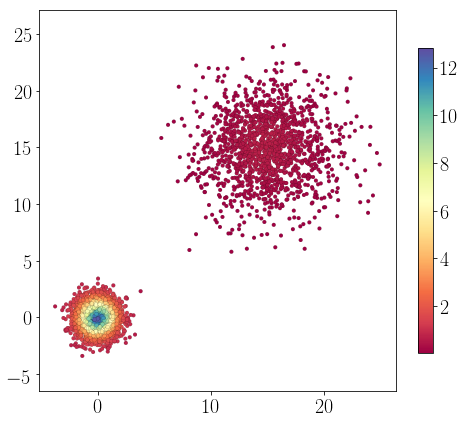

In [126]:
plot2D(X4, label= betas4, s=15, figsize=(8,7))
plt.axis('equal')

t-SNE embedding in 189.362938 sec


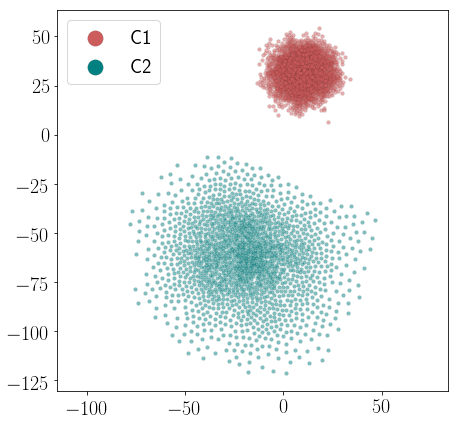

In [127]:
start = time.time()
Y_fitsne_scale4 = diffusion_tsne(
    X4, perplexity=perp, seed=42, nthreads=nthreads, 
    max_iter=10000, early_exag_coeff = 20, learning_rate = 1500,
    scale_probs=True, load_affinities = "save", 
    knn_algo='vp-tree', nbody_algo = 'Barnes-Hut')
end = time.time()
print('t-SNE embedding in %f sec' %(end-start))
betas4 = np.fromfile('betas.dat', dtype=np.dtype('d'))
degrees4 = np.fromfile('affinity_rowsums.dat', dtype=np.dtype('d'))
meandist4 = np.fromfile('mean_dists.dat', dtype=np.dtype('d'))
plot2D(Y_fitsne_scale4, label=color4,  s=15, figsize=(7,7),
      col_map = ["indianred", "teal"], alpha = 0.5)
plt.axis('equal')
leg = plt.legend(markerscale = 4)
for lh in leg.legendHandles: 
    lh.set_alpha(1)

In [246]:
z =  0.1 + betas4.shape[0] * (1 - 0.1)* betas4 / np.sum(betas4)
y = betas4.shape[0] * betas4 / np.sum(betas4)
print(np.min(betas4))
print(np.max(betas4))
print(np.min(y))
print(np.max(y))
print(np.min(z))
print(np.max(z))

np.sum(z)

0.02719402313232422
12.80517578125
0.006030493668379481
2.8396508709123256
0.10542744430154154
2.655685783821093


4500.0

(-84.31543158742618,
 52.78270377839679,
 -130.24857862813917,
 63.309278454091306)

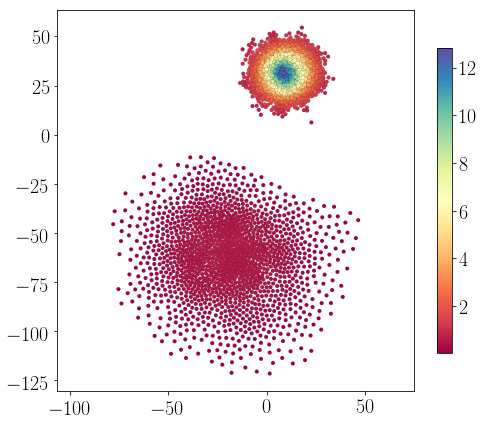

In [128]:
plot2D(Y_fitsne_scale4, label= betas4, s=15, figsize=(8,7))
plt.axis('equal')

(-84.31543158742618,
 52.78270377839679,
 -130.24857862813917,
 63.309278454091306)

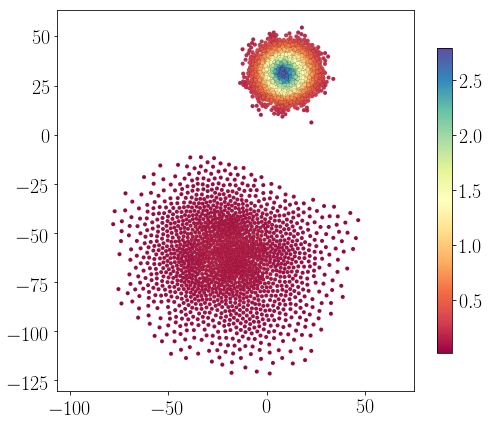

In [129]:
plot2D(Y_fitsne_scale4, label= degrees4, s=15, figsize=(8,7))
plt.axis('equal')

(-84.31543158742618,
 52.78270377839679,
 -130.24857862813917,
 63.309278454091306)

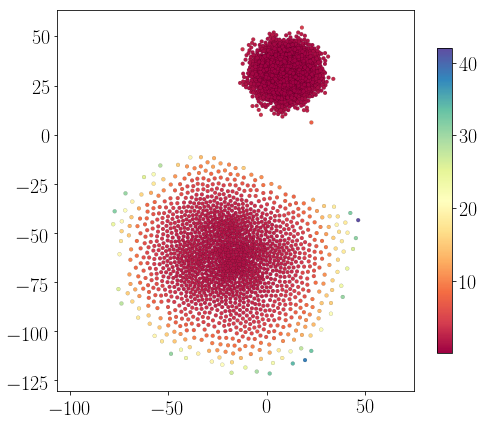

In [130]:
plot2D(Y_fitsne_scale4, label=meandist4, s=15, figsize=(8,7))
plt.axis('equal')